In [1]:
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans
import tensorflow as tf
import keras
# Import the dataset
from keras.datasets import mnist

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

C:\Users\09142640\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Training Data

In [79]:
fruit_images = []
labels = [] 
for fruit_dir_path in glob.glob("C:/Personal/09142640/Downloads/fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images=np.array(fruit_images)
labels=np.array(labels)

In [3]:
dict_id_to_label = {v:i for i,v in enumerate(np.unique(labels))}
#dict_id_to_label={i:labels_list[i] for i in range(0,len(labels_list))}
dict_label_to_id={v: k for k, v in dict_id_to_label.items()}

In [4]:
label_ids = np.array([dict_id_to_label[x] for x in labels])

# Test Data

In [5]:

fruit_images_test = []
labels_test = [] 
for fruit_dir_path in glob.glob("C:/Personal/09142640/Downloads/fruits-360/Test/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images_test.append(image)
        labels_test.append(fruit_label)
fruit_images_test=np.array(fruit_images_test)
labels_test=np.array(labels_test)

In [6]:
#labels_list=list(sorted(set(labels_test)))
dict_id_to_label_test = {v:i for i,v in enumerate(np.unique(labels_test))}
#dict_id_to_label_test={i:labels_test[i] for i in range(0,len(labels_list))}
dict_label_to_id_test={v: k for k, v in dict_id_to_label_test.items()}

In [7]:
label_ids_test = np.array([dict_id_to_label_test[x] for x in labels_test])

# Splitting the data

In [16]:
X_train, X_test = fruit_images, fruit_images_test
Y_train, Y_test = label_ids, label_ids_test

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Reshaping to a flattened version
X_train_flat = X_train.reshape(X_train.shape[0],45*45*3)
X_test_flat = X_test.reshape(X_test.shape[0],45*45*3)



#Encoding the output
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_train_flat.shape, X_test_flat.shape)

Original Sizes: (48905, 45, 45, 3) (16421, 45, 45, 3) (48905, 95) (16421, 95)
Flattened: (48905, 6075) (16421, 6075)


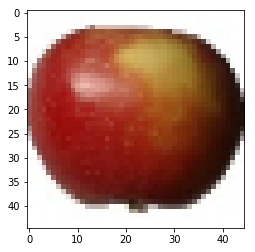

In [71]:
#print(X_train[0].shape)
plt.imshow(X_train[100])
plt.show()

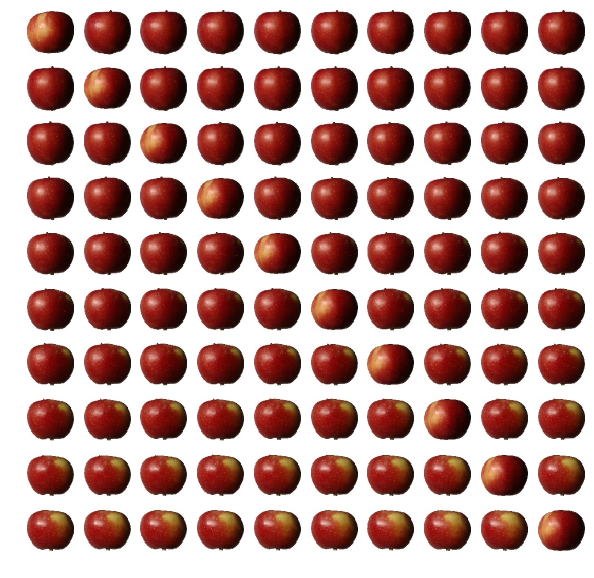

In [78]:
nb_rows=10
nb_cols=10
n=0
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))
for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            # axs[i, j].xaxis.set_ticklabels([])
            # axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].axis('off')
            axs[i, j].imshow(fruit_images[n])
            n += 1        

# Multi Layer Perceptron

In [38]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(64, activation='relu', input_shape=(X_train_flat.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(95, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(X_train_flat, Y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test_flat, Y_test))
score = model.evaluate(X_test_flat, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                388864    
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 95)                6175      
Total params: 399,199
Trainable params: 399,199
Non-trainable params: 0
_________________________________________________________________
Train on 48905 samples, validate on 16421 samples
Epoch 1/10
48905/48905 [==============================] - 55s 1ms/step - loss: 3.3447 

Acuuracy is on the lower side at 52%,lets try to check if increasing the nodes will help

In [40]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(95, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train_flat, Y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test_flat, Y_test))
score = model.evaluate(X_test_flat, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               777728    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 95)                12255     
Total params: 806,495
Trainable params: 806,495
Non-trainable params: 0
_________________________________________________________________
Train on 48905 samples, validate on 16421 samples
Epoch 1/10
48905/48905 [==============================] - 15s 300us/step - loss: 2.712

Accuracy improved significantly ,reason being nodes were doubled  and because of which loss of data was very less.

# Convolutional Neural Networks

In [51]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(45,45,3,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(95, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 48905 samples, validate on 16421 samples
Epoch 1/10
48905/48905 [==============================] - 447s 9ms/step - loss: 2.2955 - acc: 0.4040 - val_loss: 0.7570 - val_acc: 0.7640
Epoch 2/10
48905/48905 [==============================] - 441s 9ms/step - loss: 0.5003 - acc: 0.8359 - val_loss: 0.3064 - val_acc: 0.8945
Epoch 3/10
48905/48905 [==============================] - 433s 9ms/step - loss: 0.2472 - acc: 0.9147 - val_loss: 0.1727 - val_acc: 0.9436
Epoch 4/10
48905/48905 [==============================] - 413s 8ms/step - loss: 0.1615 - acc: 0.9438 - val_loss: 0.1206 - val_acc: 0.9647
Epoch 5/10
48905/48905 [==============================] - 415s 8ms/step - loss: 0.1200 - acc: 0.9579 - val_loss: 0.1329 - val_acc: 0.9594
Epoch 6/10
48905/48905 [==============================] - 417s 9ms/step - loss: 0.1009 - acc: 0.9646 - val_loss: 0.0795 - val_acc: 0.9770
Epoch 7/10
48905/48905 [==============================] - 420s 9ms/step - loss: 0.0858 - acc: 0.9701 - val_loss: 0.0978 - 

CNN performed really well here.Its accuracy was very high.The reason being CNN is ideal for image processing due to its layers-convolutional,pooling which are ideal for images.CNN is little slow because of more computations underlying.lets try to double the number of nodes.

In [52]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(45,45,3,)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(95, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 48905 samples, validate on 16421 samples
Epoch 1/5
48905/48905 [==============================] - 1114s 23ms/step - loss: 2.2659 - acc: 0.4170 - val_loss: 0.3950 - val_acc: 0.8766
Epoch 2/5
48905/48905 [==============================] - 1170s 24ms/step - loss: 0.4711 - acc: 0.8466 - val_loss: 0.8906 - val_acc: 0.7839
Epoch 3/5
48905/48905 [==============================] - 1166s 24ms/step - loss: 0.2363 - acc: 0.9206 - val_loss: 0.1575 - val_acc: 0.9543
Epoch 4/5
48905/48905 [==============================] - 1129s 23ms/step - loss: 0.1653 - acc: 0.9427 - val_loss: 0.1936 - val_acc: 0.9416
Epoch 5/5
48905/48905 [==============================] - 1114s 23ms/step - loss: 0.1240 - acc: 0.9573 - val_loss: 0.1534 - val_acc: 0.9553
Test loss: 0.15342207298049196
Test accuracy: 0.9553011387857012


# RNN

In [61]:
x_train, x_test = fruit_images, fruit_images_test
y_train, y_test = label_ids, label_ids_test
# Training parameters.
batch_size = 64
num_classes = 95
epochs = 3

# Embedding dimensions.
row_hidden = 32
col_hidden = 32

# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 45, 45, 3)
x_test = x_test.reshape(x_test.shape[0], 45, 45, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converts class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation.
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (48905, 45, 45, 3)
48905 train samples
16421 test samples
Train on 48905 samples, validate on 16421 samples
Epoch 1/3
48905/48905 [==============================] - 346s 7ms/step - loss: 3.8291 - acc: 0.0796 - val_loss: 3.1139 - val_acc: 0.1753
Epoch 2/3
48905/48905 [==============================] - 342s 7ms/step - loss: 2.6810 - acc: 0.2700 - val_loss: 2.2763 - val_acc: 0.3445
Epoch 3/3
48905/48905 [==============================] - 369s 8ms/step - loss: 2.0088 - acc: 0.4277 - val_loss: 1.9018 - val_acc: 0.4539
Test loss: 1.901784798908187
Test accuracy: 0.4539309420863528


# Conclusion

CNN was better than MLP and RNN.The only downside was, it took more time than other models because of its complex computations.CNN is ideal for image classifican due to its layers such as Convulational and Pooling.Overall, MLP performed better if we take both ,Accuracy and run time in perspective.RNN performed poorly.We can try playing with the parameters to improve the performance.